# Adversarial Example Generation

Adapted from the PyTorch tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision as tv

In [2]:
# Check the availability of GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Check # of threads in CPU
num_workers = os.cpu_count()
print(num_workers)

24


In [4]:
ROOT = './data'        # Save downloaded file to this folder
BATCH_SIZE = 128       # Size of the mini-batch
LEARNING_RATE = 0.001  # The learning rate for Stochastic Gradient Descent (SGD)
MAX_EPOCHS = 30        # # of epochs to train

## Prepare Data

MNIST database contains handwritten digits from 0 to 9.
- The training set has 60,000 examples
- The test set has 10,000 examples
- The dataset was first used by LeCun et al. (1998) for LeNet-5

In [5]:
# Download dataset
# Transform image into PyTorch tensor object
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
])

train_dataset = tv.datasets.MNIST(
    ROOT,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    ROOT,
    train=False, 
    download=True,
    transform=transform)

# PyTorch uses DataLoader to access the tensor in mini-batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

In [6]:
# Testing the DataLoader object
it = iter(train_loader)  # It 
x, y = next(it)

# In PyTorch tensor, # of channel goes before height and width
#<batch_size, channel, height, width>
print(x.size(), y.size())

# The value range is [0, 1]
print(x.min().item(), x.max().item())

torch.Size([128, 1, 28, 28]) torch.Size([128])
0.0 1.0


## Train the Neural Network Model

In [7]:
class Net(nn.Module):
    '''A neural network which is similar to LeNet-5'''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def train(model, loader, loss_fn, optimizer, device=device):
    num_samples = len(loader.dataset)
    num_batches = len(loader)

    avg_loss = 0.
    corrects = 0.
    
    model.train()  # Set mode to train
    for x, y in train_loader:
        x = x.to(device)  # Move to GPU
        y = y.to(device)
        
        optimizer.zero_grad()  # Reset gradient
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()  # Run backpropagation
        optimizer.step()
        
        # for display
        avg_loss += loss.item()
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
        
    avg_loss /= num_batches
    accuracy = corrects / num_samples
    return avg_loss, accuracy

In [9]:
def test(model, loader, loss_fn, device=device):
    num_samples = len(loader.dataset)
    num_batches = len(loader)
    
    avg_loss = 0.
    corrects = 0.
    
    model.eval()  # Set to evaluation model (Use all neurals in Dropout layer)
    with torch.no_grad():  # Disable gradient calculation
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            output = model(x)
            loss = F.nll_loss(output, y)
            
            avg_loss += loss.item()
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
        
        avg_loss /= num_batches
        accuracy = corrects / num_samples
    return avg_loss, accuracy

In [10]:
# Create a new instance of the model, and move it to GPU
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.8)
loss_fn = nn.NLLLoss()  # Negative Log Likelihood Loss

In [11]:
def time2str(time_elapsed):
    return '{:.0f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60)

In [12]:
# This model can perform better with more training epochs and learning rate scheduler
history_train_loss = []
history_test_loss = []

since = time.time()
for epoch in range(MAX_EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, train_loader, loss_fn, optimizer)
    te_loss, te_acc = test(model, test_loader, loss_fn)
    history_train_loss.append(tr_loss)
    history_test_loss.append(te_loss)
    
    time_elapsed = time.time() - start
    print('[{:2d}] {} Avg train loss: {:.4f} Accuracy: {:.2f}%, Avg test loss: {:.4f} Accuracy: {:.2f}%'.format(
        epoch+1, time2str(time_elapsed), tr_loss, tr_acc*100., te_loss, te_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {}'.format(time2str(time_elapsed)))

[ 1] 0m 2.5s Avg train loss: 2.2730 Accuracy: 21.68%, Avg test loss: 2.2184 Accuracy: 54.79%
[ 2] 0m 2.3s Avg train loss: 1.9341 Accuracy: 54.14%, Avg test loss: 1.2476 Accuracy: 72.19%
[ 3] 0m 2.2s Avg train loss: 0.8469 Accuracy: 75.27%, Avg test loss: 0.4897 Accuracy: 86.57%
[ 4] 0m 2.2s Avg train loss: 0.5136 Accuracy: 84.39%, Avg test loss: 0.3718 Accuracy: 89.15%
[ 5] 0m 2.1s Avg train loss: 0.4175 Accuracy: 87.32%, Avg test loss: 0.3129 Accuracy: 90.73%
[ 6] 0m 2.1s Avg train loss: 0.3628 Accuracy: 89.05%, Avg test loss: 0.2807 Accuracy: 91.68%
[ 7] 0m 2.2s Avg train loss: 0.3233 Accuracy: 90.25%, Avg test loss: 0.2426 Accuracy: 92.60%
[ 8] 0m 2.1s Avg train loss: 0.2912 Accuracy: 91.14%, Avg test loss: 0.2183 Accuracy: 93.33%
[ 9] 0m 2.1s Avg train loss: 0.2664 Accuracy: 91.98%, Avg test loss: 0.2000 Accuracy: 93.94%
[10] 0m 2.2s Avg train loss: 0.2432 Accuracy: 92.74%, Avg test loss: 0.1739 Accuracy: 94.63%
[11] 0m 2.2s Avg train loss: 0.2259 Accuracy: 93.24%, Avg test loss: 0

In [13]:
# Save the parameters of the model
torch.save(model.state_dict(), 'mnist_model.pt')

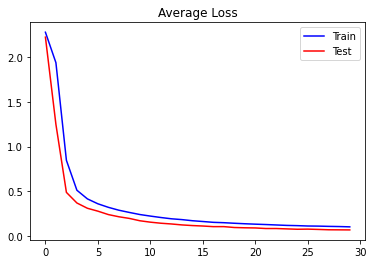

In [14]:
plt.figure()
plt.plot(history_train_loss, label='Train', c='blue')
plt.plot(history_test_loss, label='Test', c='red')
plt.legend()
plt.title('Average Loss')
plt.show()

## Generate Adversarial Example

In [15]:
# Epsilons controls the weight of adversarial perturbation
# We can think it as the percentage of the adversarial noise,
# but epsilon can be greater than 1.
EPSILONS = [0, .05, .1, .15, .2, .25, .3]

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    '''A naive implementation of the Fast Gradient Sign Method'''
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0., 1.)  # With the range of normal image e.g.[0, 1]
    return perturbed_image

In [17]:
def gen_advx(model, loader, loss_fn, eps, device=device):
    num_samples = len(loader.dataset)
    
    correct = 0
    adv_examples = []
    
    # We use evaluation mode (Without dropout) but with gradient.
    start = time.time()
    model.eval() 
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        x.requires_grad = True  # We need gradient

        output = model(x)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != y.item():
            continue  # Skip the image, if it has already mislabelled.

        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        x_grad = x.grad.data
        
        # Create adversarial examples
        perturbed_data = fgsm_attack(x, eps, x_grad)
        
        # Let the model to predict the adversarial example
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        
        # Save outputs
        if final_pred.item() == y.item():
            correct += 1
            if (eps == 0) and (len(adv_examples) < 5):
                # We need move the data from GPU to CPU
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                sample_tuple = (init_pred.item(), final_pred.item(), adv_ex)
                adv_examples.append(sample_tuple)
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                sample_tuple = (init_pred.item(), final_pred.item(), adv_ex)
                adv_examples.append(sample_tuple)

    final_acc = correct / num_samples
    time_elapsed = time.time() - start
    print("{} Epsilon = {} - Test Accuracy = {}/{} = {:.2f}%".format(
        time2str(time_elapsed), eps, correct, num_samples, final_acc*100.))
    return final_acc, adv_examples

In [18]:
# gradient should based on single input
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True)

accuracies = []
examples = []

since = time.time()
for eps in EPSILONS:
    acc, ex = gen_advx(model, test_loader, loss_fn, eps)
    accuracies.append(acc)
    examples.append(ex)

time_elapsed = time.time() - since
print('Total run time: {}'.format(time2str(time_elapsed)))

0m 13.0s Epsilon = 0 - Test Accuracy = 9774/10000 = 97.74%
0m 11.7s Epsilon = 0.05 - Test Accuracy = 9258/10000 = 92.58%
0m 12.1s Epsilon = 0.1 - Test Accuracy = 7905/10000 = 79.05%
0m 12.4s Epsilon = 0.15 - Test Accuracy = 5458/10000 = 54.58%
0m 12.3s Epsilon = 0.2 - Test Accuracy = 2811/10000 = 28.11%
0m 12.2s Epsilon = 0.25 - Test Accuracy = 1155/10000 = 11.55%
0m 12.1s Epsilon = 0.3 - Test Accuracy = 375/10000 = 3.75%
Total run time: 1m 25.8s


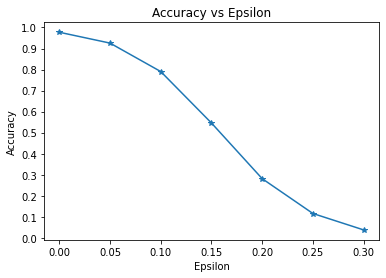

In [19]:
plt.figure()
plt.plot(EPSILONS, accuracies, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

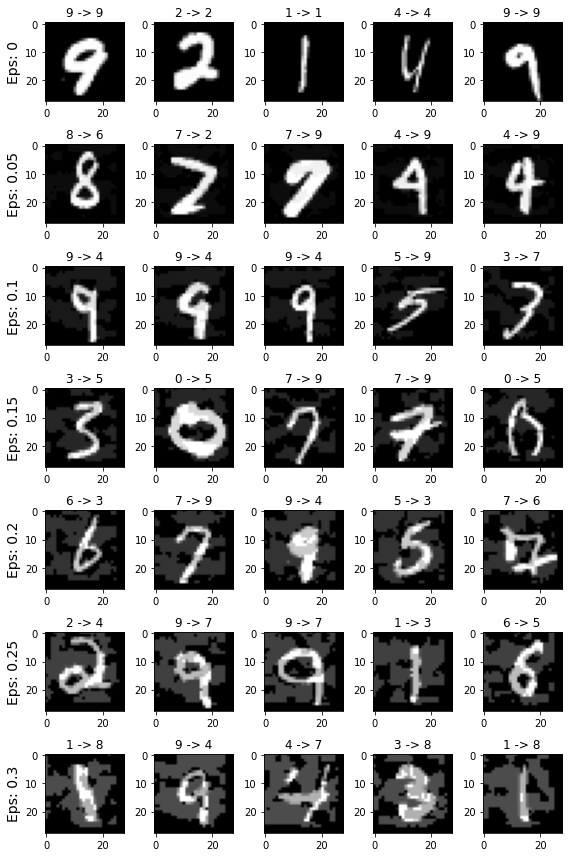

In [20]:
count = 0
plt.figure(figsize=(8, 12))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        count += 1
        ax = plt.subplot(len(EPSILONS),len(examples[0]),count)
        if j == 0:
            ax.set_ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()